## 1. 赛题理解
### 赛制要点

本次赛事目前只开放学习赛阶段

- 学习赛第一期（2024年12月2日～2025年3月3日）
- 赛季时间/报名起止时间/上传结果起止时间/测评起止时间均为【2024年12月2日12:00:00～2025年3月3日12:00:00】。

- 赛程期间系统实时评测，整点刷新排名，每人每天最多提交5次。

### 任务

对新闻文本的类别进行预测。比赛提供了包含14个新闻类别的文本数据，分为训练集和测试集A，B。训练集包含20万条新闻文本数据，测试集A，B分别包含5万条新闻文本数据。所有的新闻文本按照**字符级别进行了匿名处理**。

<img src="./imgs/tianchi-data.jpg" class="center-image" style="display: block; margin-left: auto; margin-right: auto; width: 70%;">

赛题数据来源为互联网上的新闻，通过收集并匿名处理得到。因此选手可以自行进行数据分析，可以充分发挥自己的特长来完成各种特征工程，不限制使用任何外部数据和模型。

数据列使用`\t`进行分割，Pandas读取数据的代码如下：
```python
train_df = pd.read_csv('../input/train_set.csv', sep='\t')
```
### 评测标准

<img src="./imgs/tianchi-eval.jpg" class="center-image" style="display: block; margin-left: auto; margin-right: auto; width: 70%;">

### 提交评测方法

通过提交文件来触发评测：提交前请确保预测结果的格式与sample_submit.csv中的格式一致，以及提交文件后缀名为csv。

## 2. 方案选型
对于成熟的算法任务，我们能想到的方案都能网上套，而且在开源生态做得如此好的今天，我们可以找到大量的现成代码来快速完成实验。

这个任务的数据量足够大，那我们就不用再从传统机器学习那一块去尝试了，直接上深度学习模型就完事了，比如非常经典的Fasttext、TextCNN。当然我们学完BERT后肯定是无脑上BERT。

学习赛的一个好处就是能站在前人的肩膀上进行优化，大家可以在比赛论坛里查看benchmark实现思路和一些优化方案：https://tianchi.aliyun.com/competition/entrance/531810/forum

比较典型的有：

- FastText：https://tianchi.aliyun.com/notebook/118255
- TextRNN：https://tianchi.aliyun.com/notebook/118259
- 基于Bert的模型融合方案：https://tianchi.aliyun.com/forum/post/128734

下面我们就用BERT作为基础模型来实现一个Baseline方案

### 整体思路

用BERT来做这个分类任务，首先要考虑到的BERT的优势来源于预训练，但问题是这个任务把数据都脱敏了，我们没办法把文本直接映射到现有模型的词表上去，所以我们得自己重新切词、预训练、微调，这样才能得到一个适用于当前任务的模型。

### 数据分析
#### 读取数据

In [1]:
# 文件读取
import pandas as pd
from datasets import load_dataset
from datasets import Dataset

train_df = pd.read_csv('./data/train_set.csv', sep="\t")
test_df = pd.read_csv('./data/test_a.csv', sep="\t")
df = pd.concat((train_df, test_df))
df.head()

,label,text
0,2.0,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11.0,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3.0,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2.0,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3.0,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


#### 整体分布

以训练集为分析数据。总共包括20万条新闻以及对应的标签数据 。新闻标签共有14个类别，符号对应关系如下：{‘科技’: 0, ‘股票’: 1, ‘体育’: 2, ‘娱乐’: 3, ‘时政’: 4, ‘社会’: 5, ‘教育’: 6, ‘财经’: 7, ‘家居’: 8, ‘游戏’: 9, ‘房产’: 10, ‘时尚’: 11, ‘彩票’: 12, ‘星座’: 13}。不同类别的数据分布如下图所示：

/tmp/ipykernel_201/4143202343.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


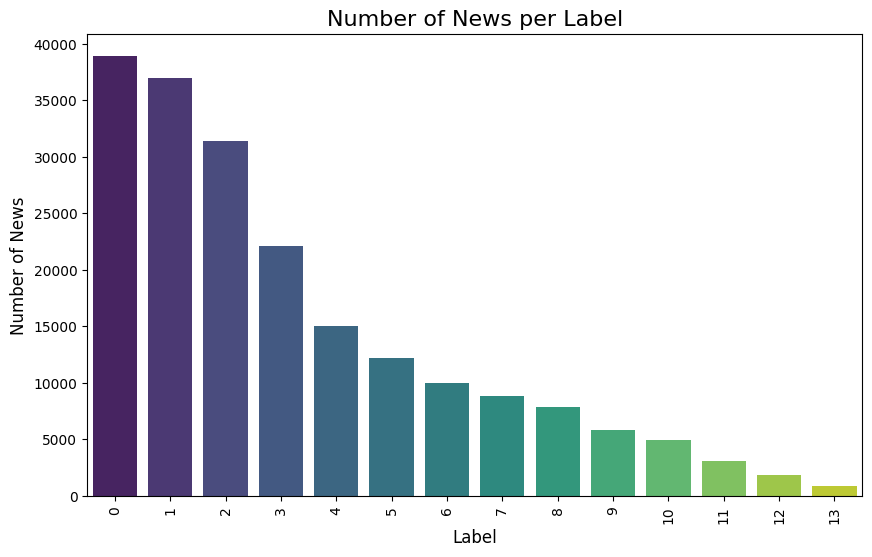

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假设你的DataFrame是train_df，并且标签列是'label'
label_counts = train_df['label'].value_counts()  # 统计每个标签的数量

# 按数量从大到小排序
label_counts = label_counts.sort_values(ascending=False)

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# 设置图表的标题和标签
plt.title('Number of News per Label', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of News', fontsize=12)

# 显示图表
plt.xticks(rotation=90)  # 旋转横坐标标签，防止重叠
plt.show()


注意到类别的新闻数量差距较大，因此在使用模型进行分类预测时需要考虑到类别不平衡的问题。

对于这20万条新闻信息，新闻文本长度的统计结果如下所示：

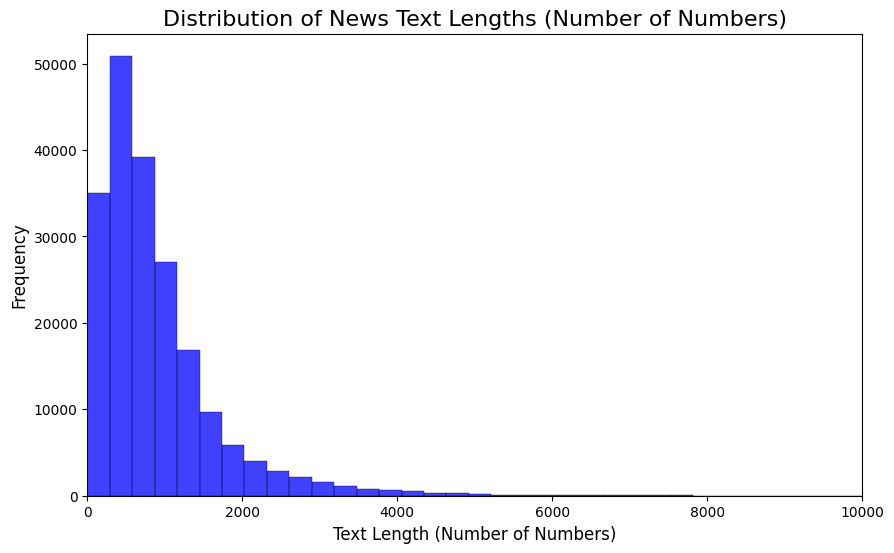

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每条新闻文本中数字的个数（按空格分隔）
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=200, kde=False, color='blue')

# 设置横坐标范围（可选）
plt.xlim(0, 10000)

# 设置图表标题和标签
plt.title('Distribution of News Text Lengths (Number of Numbers)', fontsize=16)
plt.xlabel('Text Length (Number of Numbers)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 显示图表
plt.show()

In [4]:
train_df['text_length'].describe()

count    200000.000000
mean        907.207110
std         996.029036
min           2.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
Name: text_length, dtype: float64

#### 脱敏后的字符分析

数据脱敏是常见的比赛数据操作，本意是防止数据中敏感信息导致不必要的麻烦、也杜绝了参赛者在数据上做文章的可能。

虽然我们没办法还原数据的原始状态，但还是能使用一些简单的统计手段来分析这些脱敏后的id。新闻文本一共包含6869个字符id，其分布情况如下所示：

- mean 26414.5
- std 146124.1
- min 1.0
- max 7482224.0
- 25% 25.0
- 50% 459.0
- 75% 7258.0

其中数量最多的前20个字符如下图所示：

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31526 (\N{CJK UNIFIED IDEOGRAPH-7B26}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


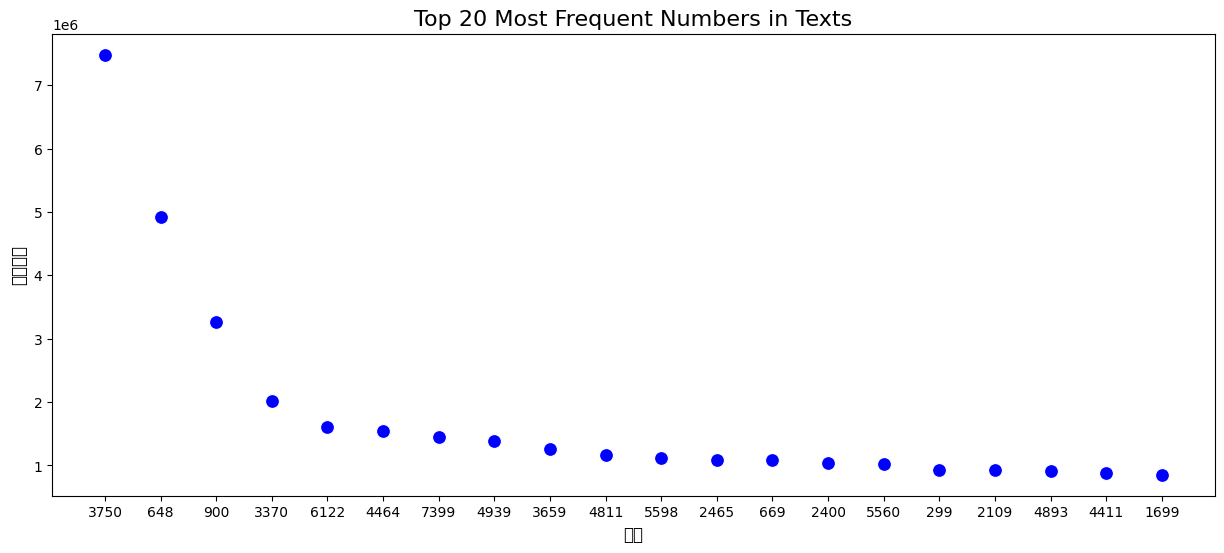

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 提取所有文本中的数字字符
all_text = " ".join(train_df['text'])  # 合并所有文本为一个字符串
all_numbers = all_text.split()  # 按空格分隔，提取出所有数字

# 统计每个数字的出现次数
counter = Counter(all_numbers)

# 获取出现次数最多的前20个数字字符
top_20_numbers = counter.most_common(20)

# 分离出数字字符和对应的出现次数
numbers, counts = zip(*top_20_numbers)

# 绘制散点图
plt.figure(figsize=(15, 6))
sns.scatterplot(x=numbers, y=counts, color='blue',markers='*', s=100)

# 设置图表标题和标签
plt.title('Top 20 Most Frequent Numbers in Texts', fontsize=16)
plt.xlabel('字符', fontsize=12)
plt.ylabel('字符数量', fontsize=12)

# 显示图表
plt.show()


In [6]:
len(counter)    # 字符数量为 6869个

6869

可以看到`3750`，`900`和`648`这三个字符的覆盖率非常高，很有可能是标点符号。有了标点我们就能对文本进行切分，可以简单算一下文本包含的句子数量：

- mean 81.0
- std 87.0
- min 1.0
- max 3460.0
- 25% 29.0
- 50% 57.0
- 75% 103.0

新闻文本平均由81条短句组成。

### 方案实现
BERT 模型
1. 重新构建词表
2. 在新词表上做预训练
3. 微调
#### 准备环境和数据


In [1]:
# 文件读取
import pandas as pd
from datasets import load_dataset
from datasets import Dataset

train_df = pd.read_csv('./data/train_set.csv', sep="\t")
test_df = pd.read_csv('./data/test_a.csv', sep="\t")
df = pd.concat((train_df, test_df))
df.head()

,label,text
0,2.0,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11.0,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3.0,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2.0,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3.0,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


#### 构建分词器
这里我们需要把上面的数据分析出来的三个标点回填到原文中，帮助分词

In [2]:
# 将3750/648/900改成标点符号，删除原text列，新增words列重命名为text列
import re
def replacepunc(x):
    x = re.sub('3750', ',', x)
    x = re.sub('900', '.', x)
    x = re.sub('648', '!', x)
    return x

df['words'] = df['text'].map(lambda x: replacepunc(x))
df.drop('text', axis=1, inplace=True)
df.columns = ['label', 'text']

# 数据载入dataset，去除多余的列，只保留text列
data = Dataset.from_pandas(df).remove_columns(['label', '__index_level_0__'])

In [3]:
df.head()

,label,text
0,2.0,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11.0,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3.0,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2.0,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3.0,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


接下来手动构建分词器的训练流程，经过这个流程你就能对BERT的分词处理有一个更详细的认识。

In [5]:
batch_size = 100
def batch_iterator():
    for i in range(0, len(data), batch_size):
        yield data['text'][i : i + batch_size]

# 设置分词器并进行训练
# 初始化分词器、预分词器
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]

# 上面通过数据分析知道字符数量是6.9k，所以词表大小设置为7k
trainer = trainers.WordPieceTrainer(vocab_size=7000, min_frequency=2, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

tokenizer.decodes = decoders.WordPiece(prefix="##") # wordpiece的前缀

# 开始训练
# tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

In [4]:
# 进行分词后处理
# cls_token_id = tokenizer.token_to_id("[CLS]")
# sep_token_id = tokenizer.token_to_id("[SEP]")
# mask_token_id = tokenizer.token_to_id("[MASK]")
# pad_token_id = tokenizer.token_to_id("[PAD]")

# tokenizer.post_processor = processors.TemplateProcessing(
#     single=f"[CLS]:0 $A:0 [SEP]:0",
#     pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
#     special_tokens=[("[CLS]",cls_token_id),("[SEP]",sep_token_id),("[MASK]",mask_token_id)],
#     )

# tokenizer.enable_truncation(max_length=512) # 原生的bert最大长度是512
# tokenizer.enable_padding(pad_token='[PAD]')

In [5]:
# 测试分词结果
# encoding = tokenizer.encode('2491 4109 1757 7539 648 3695 3038 4490 23 7019 3731 4109 3792 2465',' 2893 7212 5296 1667 3618 7044 1519 5413 1283 6122 4893 7495 2435 5510')
# print(encoding.tokens)
# print(encoding.ids)

In [6]:
"""保存模型并重新加载
tokenizer已经完成，我们必须将它放在与我们要使用的模型相对应的标记器 fast 类。
正在构建的分词器与 Transformers 中的任何类都不匹配(分词器非常特殊)，
您可以将它包装在 PreTrainedTokenizerFast 中"""
# tokenizer.save("tokenizer.json")

'保存模型并重新加载\ntokenizer已经完成，我们必须将它放在与我们要使用的模型相对应的标记器 fast 类。\n正在构建的分词器与 Transformers 中的任何类都不匹配(分词器非常特殊)，\n您可以将它包装在 PreTrainedTokenizerFast 中'

In [7]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json",
                                         model_max_length=512,mask_token='[MASK]',pad_token='[PAD]',
                                         unk_token='[UNK]',cls_token='[CLS]',sep_token='[SEP]',
                                         padding_side='right',return_special_tokens_mask=True)

# PreTrainedTokenizerFast中一定要设置mask_token, pad_token等，不然mlm报错没有设定mask_token以及分词器无法padding

encoding_list = fast_tokenizer.encode('2491 4109 1757 7539 648 3695 3038 4490 23 7019 3731 4109 3792 2465',' 2893 7212 5296 1667 3618 7044 1519 5413 1283 6122 4893 7495 2435 5510')
print(encoding_list)

[1, 1377, 456, 1309, 231, 709, 20, 786, 567, 272, 70, 1214, 1026, 456, 533, 129, 2, 2548, 703, 274, 286, 332, 461, 157, 993, 932, 97, 143, 245, 753, 359, 2]


#### 预训练Bert模型

In [8]:
# data_collator是一个函数，负责获取样本并将它们批处理成张量
# 在data_collator中可以确保每次以新的方式完成随机掩蔽。

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=fast_tokenizer, 
                                                mlm=True, mlm_probability=0.15)

2025-02-17 20:23:14.899822: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 20:23:15.187953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 20:23:16.126190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# 初始化bert模型，参数参考讨论区代码
from transformers import BertConfig
config = BertConfig(
    vocab_size=7000,
    hidden_size=512,
    intermediate_size=4 * 512,
    max_position_embeddings=512,
    num_hidden_layers=4,
    num_attention_heads=4,
    type_vocab_size=2
)

from transformers import BertForMaskedLM
model = BertForMaskedLM(config=config)

from transformers import BertForMaskedLM
# model = BertForMaskedLM.from_pretrained()

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [10]:
# 数据进行分词预处理，删除'text'列，否则后面拼接的时候会报错
tokenized_datasets = data.map(lambda examples: 
    fast_tokenizer(examples['text']), batched=True).remove_columns("text")

Map:   0%|          | 0/250000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1061 > 512). Running this sequence through the model will result in indexing errors


In [11]:
print(type(tokenized_datasets))
for i, data in enumerate(tokenized_datasets):
    print(data.keys())
    print(len(data['input_ids']))
    # print(data)
    break

data = tokenized_datasets[:3]
# print(data)
concatenated_examples = {k: sum(data[k], []) for k in data.keys()}
# print(concatenated_examples)

<class 'datasets.arrow_dataset.Dataset'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
1061


In [ ]:
# 拼接所有文本
block_size = 128

def group_texts(examples, block_size=128):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # 我们将余数对应的部分去掉，但如果模型支持的话，可以添加padding，您可以根据需要定制此部件。
    total_length = (total_length // block_size) * block_size
    # 通过max_len进行分割
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["lables"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=500,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/250000 [00:00<?, ? examples/s]

In [ ]:
# 加载和保存拼接后的文本，掉线的时候这么做
# lm_datasets.save_to_disk('./lm')
import pandas as pd
from datasets import load_from_disk
lm_datasets=load_from_disk('./lm')

# 解码分词器预处理的lm_datasets数据，里面有标点符号
la=fast_tokenizer.decode(lm_datasets[0]['input_ids'])
print(la)

下面开始训练模型：

In [ ]:
# 使用GPU训练，运行这段代码
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# 设定args和trainer准备训练，3000步看一次loss，9000步保存一次模型
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    "Test-Clm",
    logging_strategy="steps",
    logging_steps=3000,
    save_strategy="steps",
    save_steps=9000,
    num_train_epochs=2,
    learning_rate=3e-4,
    per_device_train_batch_size=96,
    weight_decay=0.01)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets,
    data_collator=data_collator
)

# 训练并保存模型
trainer.train()

trainer.save_model("./pre_Bert")

### 分类任务微调训练

#### 1. 加载预训练好的模型

In [1]:
from transformers import AutoModelForSequenceClassification
model=AutoModelForSequenceClassification.from_pretrained("./pre_Bert", num_labels=14)

# 使用GPU进行训练
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

2025-02-17 21:36:29.973019: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 21:36:30.018957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 21:36:30.834741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pre_Bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably T

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(7000, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12

#### 2. 读取数据集，准备进行预处理

In [2]:
from datasets import Dataset
import pandas as pd
import re

def replacepunc(x):
    x = re.sub('3750', ',', x)
    x = re.sub('900', '.', x)
    x = re.sub('648', '!', x)
    return x
    
# 读取数据并shuffle
train_df = pd.read_csv('./data/train_set.csv', sep='\t').sample(frac=1)

# 将训练数据中的三个token换成标点
train_df['texts']=train_df['text'].map(lambda x:replacepunc(x))

# 准备将text文本首尾截断，各取255tokens
def slipt2(x):
    ls=x.split(' ')
    le=len(ls)
    if le<511:
        return x
    else:
        return ' '.join(ls[:255]+ls[-255:])

In [3]:
train_df.shape, train_df.head()

((200000, 3),
         label                                               text  \
 53646       2  7154 1335 3772 6012 1833 5385 3793 1219 212 74...   
 56610       1  2592 4181 2693 6713 5612 7467 7449 3692 3809 3...   
 146933      1  1241 7097 5036 4216 1906 2380 5620 5681 2465 1...   
 74397       4  1141 4411 1805 1232 4630 2791 6861 6654 1362 4...   
 194875      2  1582 2810 5297 3731 4109 3792 2522 6032 591 81...   
 
                                                     texts  
 53646   7154 1335 3772 6012 1833 5385 3793 1219 212 74...  
 56610   2592 4181 2693 6713 5612 7467 7449 3692 3809 3...  
 146933  1241 7097 5036 4216 1906 2380 5620 5681 2465 1...  
 74397   1141 4411 1805 1232 4630 2791 6861 6654 1362 4...  
 194875  1582 2810 5297 3731 4109 3792 2522 6032 591 81...  )

#### 3.划分训练集和测试集比例9:1

In [4]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json",
                                         model_max_length=512,mask_token='[MASK]',pad_token='[PAD]',
                                         unk_token='[UNK]',cls_token='[CLS]',sep_token='[SEP]',
                                         padding_side='right',return_special_tokens_mask=True)

In [10]:
val_df = train_df.iloc[:20000, ]
trains_df = train_df.iloc[20000:, ]

# 首尾截断
val_df['summary'] = val_df['texts'].apply(lambda x: slipt2(x))
trains_df['summary'] = trains_df['texts'].apply(lambda x: slipt2(x))

# 加载到dataset并预处理
trains_ds = Dataset.from_pandas(trains_df).remove_columns(["texts", "text"])
val_ds = Dataset.from_pandas(val_df).remove_columns(["texts", "text"])

tokenized_trains_ds = trains_ds.map(lambda examples:
                                   fast_tokenizer(examples['summary'], truncation=True, padding=True),
                                   batched=True)
tokenized_val_ds = val_ds.map(lambda examples:
                                   fast_tokenizer(examples['summary'], truncation=True, padding=True),
                                   batched=True)

/tmp/ipykernel_7522/1298721600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['summary'] = val_df['texts'].apply(lambda x: slipt2(x))
/tmp/ipykernel_7522/1298721600.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains_df['summary'] = trains_df['texts'].apply(lambda x: slipt2(x))


  0%|          | 0/180 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

#### 4. 设置TrainingArguments和Trainer

In [7]:
# 导入所需库
from datasets import load_metric
import numpy as np

# 加载准确率评估指标
metric = load_metric("accuracy")

# 定义一个简单的计算准确率的函数
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)  # 获取预测的类别标签
    return metric.compute(predictions=predictions, references=labels)

# 测试 compute_metrics 函数
eval_pred = ([[0.1, 0.8, 0.1], [0.2, 0.2, 0.6], [0.9, 0.05, 0.05]], [1, 2, 0])  # 模拟预测和标签数据
results = compute_metrics(eval_pred)

# 打印结果
print("计算结果：", results)


计算结果： {'accuracy': 1.0}


In [11]:
import logging
import numpy as np
from transformers import TrainingArguments, Trainer

# 加载准确率评估指标
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return metric.compute(predictions=predictions, references=labels)

#进行任务微调
from transformers import TrainingArguments, Trainer
args=TrainingArguments(
    output_dir='news-classification-2',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=96,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=10  # 每隔10个训练步骤输出一次日志
)

trainer=Trainer(
    model,
    args,
    train_dataset=tokenized_trains_ds,
    eval_dataset=tokenized_val_ds,
    tokenizer=fast_tokenizer,
    compute_metrics=compute_metrics)

trainer.train()
trainer.save_model("./finally_bert")

/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_7522/1436940158.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


[2025-02-17 21:42:02,235] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /root/.triton/autotune: 没有那个文件或目录


Epoch,Training Loss,Validation Loss,Accuracy
1,0.187400,0.161775,0.952200
2,0.130900,0.138128,0.957550
3,0.112500,0.129746,0.959900
4,0.095600,0.126316,0.962000
5,0.089100,0.123622,0.963100
6,0.060200,0.124411,0.963750


### 生成提交文件

In [12]:
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset

# 加载tokenizer
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json",
                                         model_max_length=512,mask_token='[MASK]',pad_token='[PAD]',
                                         unk_token='[UNK]',cls_token='[CLS]',sep_token='[SEP]',
                                         padding_side='right',return_special_tokens_mask=True)

# 假设模型和tokenizer已经被保存到"./finally_bert"目录
model_path = "./finally_bert"

# 加载模型
model = BertForSequenceClassification.from_pretrained(model_path)

# 读取测试集并预处理
test_df = pd.read_csv('./data/test_a.csv', sep='\t')
test_df['texts'] = test_df['text'].map(lambda x: replacepunc(x))  # 确保replacepunc函数已经定义
test_df['summary'] = test_df['texts'].apply(lambda x: slipt2(x))  # 确保slipt2函数已经定义

# 加载到dataset并预处理
test_ds = Dataset.from_pandas(test_df).remove_columns(["texts", "text"])
tokenized_test_ds = test_ds.map(lambda examples: fast_tokenizer(examples['summary'], truncation=True, padding=True), batched=True)

# 实例化Trainer进行预测
from transformers import Trainer

trainer = Trainer(model=model)

# 进行预测
predictions = trainer.predict(tokenized_test_ds).predictions
pred = np.argmax(predictions, axis=1)

# 保存预测结果
pd.DataFrame({'label': pred}).to_csv('submit1022.csv', index=None)

  0%|          | 0/50 [00:00<?, ?ba/s]